In [1]:
#run in case required libaraies are not installed
!pip install torch
!pip install pykan
!pip install numpy
!pip install imageio

ERROR: unknown command "imageio"


In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from kan import *
import imageio

# Define the neural network
class PIKAN(nn.Module):
    def __init__(self):
        super(PIKAN, self).__init__()
        self.knn = KAN(width=[2,2,1], grid=5, k=3,
                       #grid_eps=1.0,
                       #noise_scale_base=0.25
                      )
    def forward(self, x):
        x = self.knn(x)
        return x

# Function to compute the loss
def pikan_loss(model, x, t, u_true, lambda_phys=1.0, lambda_bc=1.0, lambda_ic=1.0):
    # Ensure requires_grad is True for x and t
    x.requires_grad = True
    t.requires_grad = True
    
    X = torch.cat((x, t), dim=1)
    
    
    # Compute the neural network output
    u_pred = model(X)
    
    # Compute gradients for PDE
    u_t = autograd.grad(u_pred, t, torch.ones_like(u_pred), retain_graph=True, create_graph=True)[0]
    u_tt = autograd.grad(u_t, t, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_x = autograd.grad(u_pred, x, torch.ones_like(u_pred), retain_graph=True, create_graph=True)[0]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    
    # Physics-based loss (PDE loss)
    f = u_tt - u_xx
    loss_phys = torch.mean(f**2)
    
    # Boundary condition loss
    x0 = torch.zeros_like(t.reshape(-1, 1), requires_grad=True) # at x = 0, u =0
    xL = torch.ones_like(t.reshape(-1, 1), requires_grad=True) # at x = 
    u_0 = model(torch.cat([x0, t.reshape(-1, 1)], dim=1))
    u_L = model(torch.cat([xL, t.reshape(-1, 1)], dim=1))
    loss_bc = torch.mean(u_0**2) + torch.mean(u_L**2)
    
    # Initial condition loss
    t0 = torch.zeros_like(x.reshape(-1, 1), requires_grad=True)
    u_0_pred = model(torch.cat([x.reshape(-1, 1), t0], dim=1))
    u_0_true = u_true
    u_t0_pred = autograd.grad(u_0_pred, t0, torch.ones_like(u_0_pred), retain_graph=True, create_graph=True)[0]
    u_t0_true = torch.zeros_like(u_t0_pred)
    loss_ic = torch.mean((u_0_pred - u_0_true)**2) + torch.mean((u_t0_pred - u_t0_true)**2)
    
    # Total loss
    total_loss = lambda_phys * loss_phys + lambda_bc * loss_bc + lambda_ic * loss_ic
    
    return total_loss

# Function to train the model
def train(model, x_train, t_train, u_train, lr, num_epochs,lambda_phys=1.0, lambda_bc=10.0, lambda_ic=10.0):
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = LBFGS(model.parameters(), lr=0.05, history_size=5, line_search_fn="strong_wolfe",)
    for epoch in range(num_epochs):
        def closure():
            global loss
            optimizer.zero_grad()
            loss = pikan_loss(model, x_train, t_train, u_train,lambda_phys=lambda_phys, lambda_bc=lambda_bc, lambda_ic=lambda_ic)
            loss.backward()
            return loss
        optimizer.step(closure)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return model

# Generate some example input data
x_train = torch.linspace(0, 2, 100).reshape(-1, 1)
t_train = torch.linspace(0, 1, 100).reshape(-1, 1)
u_true = torch.sin(torch.pi * x_train)  # Initial condition

# Ensure requires_grad is True for the example input data

# Initialize and train the model
model = PIKAN()
model = train(model, x_train, t_train, u_true, lr=0.005, num_epochs=200)

Epoch 0, Loss: 2.6487135887145996
Epoch 100, Loss: 0.029765356332063675


/opt/homebrew/anaconda3/envs/pykan-env/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


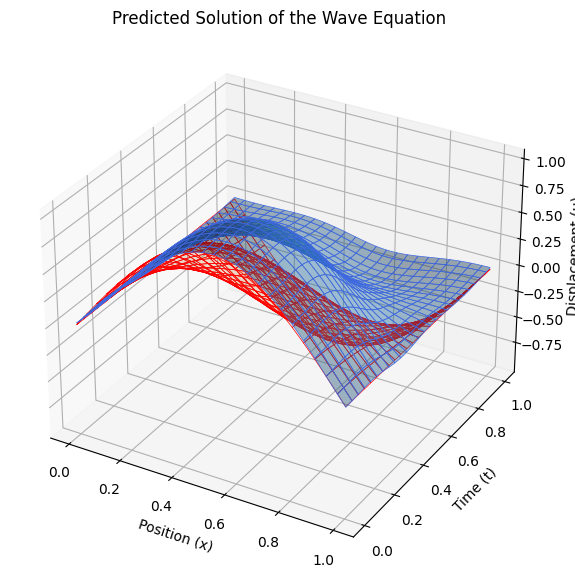

In [2]:
# Plot the solution
def plot_solution(model, x, t):
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())  # Ensure the tensors are 1D
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    with torch.no_grad():
        U_pred = model(torch.cat([X_flat, T_flat], dim=1))
    U_pred = U_pred.reshape(X.shape).numpy()
    
    # Real solution
    U_real = np.sin(np.pi * X.detach().numpy()) * np.cos(np.pi * T.detach().numpy())
    
    fig = plt.figure(figsize=(14, 7))
    
    # Predicted solution
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_surface(X.detach().numpy(), T.detach().numpy(), U_pred, edgecolor='royalblue', lw=0.5, rstride=4, cstride=4, alpha = 0.4)
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Time (t)')
    ax1.set_zlabel('Displacement (u)')
    ax1.set_title('Predicted Solution of the Wave Equation')
    
    # Real solution
    ax1.plot_surface(X.detach().numpy(), T.detach().numpy(), U_real, edgecolor='red', lw=0.5, rstride=4, cstride=4,alpha=0.1)

    
    plt.show()

def create_gif_frames(model, x, t_values, gif_filename='wave_equation.gif'):
    frames = []
    for t in t_values:
        t_tensor = torch.full_like(x, t, requires_grad=False)
        with torch.no_grad():
            U_pred = model(torch.cat([x, t_tensor], dim=1)).numpy()
        plt.figure()
        plt.plot(x.detach().numpy(), U_pred, label='Predicted', color='blue')
        plt.plot(x.detach().numpy(), np.sin(np.pi * x.detach().numpy()) * np.cos(np.pi * t), label='Real', color='red')
        plt.xlabel('Position (x)')
        plt.ylabel('Displacement (u)')
        plt.title(f'Time (t) = {t:.2f}')
        plt.legend()
        plt.ylim(-1, 1)
        plt.grid(True)
        
        # Save frame
        frame_filename = f'frame_{t:.2f}.png'
        plt.savefig(frame_filename)
        plt.close()
        frames.append(imageio.imread(frame_filename))
        
    # Create GIF
    imageio.mimsave(gif_filename, frames, duration=0.1)
    print(f'GIF saved as {gif_filename}')

# Generate frames and create GIF
t_values = np.linspace(0, 1, 40)
#create_gif_frames(model, x_train, t_values)
# Plot the predicted solution

plot_solution(model, torch.linspace(0,1,100), t_train)


In [4]:
def create_gif_frames(model, x, t_values, gif_filename='wave_equation.gif'):
    frames = []
    for t in t_values:
        t_tensor = torch.full_like(x, t, requires_grad=False)
        with torch.no_grad():
            U_pred = model(torch.cat([x, t_tensor], dim=1)).numpy()
        plt.figure()
        plt.plot(x.detach().numpy(), U_pred, label='KAN Predicted', color='blue')
        plt.plot(x.detach().numpy(), np.sin(np.pi * x.detach().numpy()) * np.cos(np.pi * t), label='Real', color='red')
        plt.xlabel('Position (x)')
        plt.ylabel('Displacement (u)')
        plt.title(f'Time (t) = {t:.2f}')
        plt.legend()
        plt.ylim(-1, 1)
        plt.grid(True)
        
        # Save frame
        frame_filename = f'frame_{t:.2f}.png'
        plt.savefig(frame_filename)
        plt.close()
        frames.append(imageio.imread(frame_filename))
        
    # Create GIF
    imageio.mimsave(gif_filename, frames, duration=0.1)
    print(f'GIF saved as {gif_filename}')
    
t_values = np.linspace(0, 1, 40)

create_gif_frames(model, torch.linspace(0,1,40).reshape(-1, 1), t_values, gif_filename='wave_equation_PIKAN.gif')

/var/folders/cn/d10dnmx96hbc42y3fr8bqt9c0000gn/T/ipykernel_78494/3554275899.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_filename))


GIF saved as wave_equation_PIKAN.gif


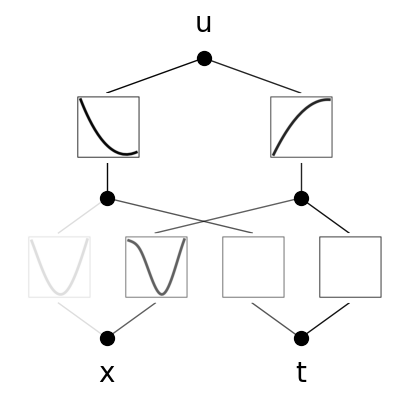

In [7]:
model.knn.plot(in_vars = ['x','t'], out_vars = ['u'])
plt.savefig('PIKAN_plot_wave.png', transparent = True)